## TFIDF 구현

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from konlpy.tag import *
import nltk
import re

In [2]:
df = pd.read_csv('./data/tf-idf_sampledata.csv')
df.head(3)

,Unnamed: 0,회사명,직무명,채용공고명,주요업무,자격요건,우대사항,기술스택
0,6,베이스라인파트너스,웹 개발자,"Cloud(AWS,GCP) 기반 운영 및 개발 담당자","• DB단 개발 및 데이터 관리\r\n\r\n\r\n[ 필수제출서류: 이력서,경력...",AWS / linux / gitLab / DB(mysql) / EKS(K8S) /...,AWS 운영 경험 / 개발(python/java 등) 경험 보유자,GitLab\r\nLinux\r\nMySQL\r\nHTML\r\nJava\r\nAW...
1,11,제이씨현시스템,웹 개발자,ASP.NET 웹개발자,• 웹사이트 개발 및 유지보수\r\n• 서류전형 - 1차(실무면접) - 2차(임원면...,"• C# ASP.NET webform, MS-SQL DB 사용 가능자\r\n• ...",•협업 및 커뮤니케이션 우수자\r\n•관련 학과 전공자\r\n•관련 자격증 보유자\...,C / C++\r\nHTML\r\nJavaScript\r\nSQL
2,59,단색,웹 개발자,웹 개발자,• 고도몰5 디자인 수정\r\n• 고도몰5 커스텀 튜닝 개발\r\n• MySQL 데...,"• HTML, CSS, jQuery, PHP, MySQL","- 스스로 문제를 정의하고 해결 가능하신 분\r\n- 동종업계, 웹에이전시 경험 있...",MySQL\r\nHTML\r\nPHP\r\nSQL


- • \r\n () []

In [3]:
# 간단한 데이터처리를 수행합니다. 눈에 보이는 것만 처리해서 다른 기호도 가끔 눈에 보입니다. 추가 처리가 필요합니다.
def prep(data):
    
    data['자격요건'] = data['자격요건'].str.replace('[-•·*\r\n\(\)\[\]\/:ㆍ\<\>＜＞［］]', ' ', regex = True)
    data['우대사항'] = data['우대사항'].str.replace('[-•·*\r\n\(\)\[\]\/:ㆍ\<\>＜＞［］]', ' ', regex = True)
    data['주요업무'] = data['주요업무'].str.replace('[-•·*\r\n\(\)\[\]\/:ㆍ\<\>＜＞［］]', ' ', regex = True)
    data['채용공고명'] = data['채용공고명'].str.replace('[-•·*\r\n\(\)\[\]\/:ㆍ\<\>＜＞［］]', ' ', regex = True)
    data['기술스택'] = data['기술스택'].str.replace('\r\n', ', ')
    
    return data

In [4]:
dfc = df.copy()
d = prep(dfc)
d.head(3)

,Unnamed: 0,회사명,직무명,채용공고명,주요업무,자격요건,우대사항,기술스택
0,6,베이스라인파트너스,웹 개발자,"Cloud AWS,GCP 기반 운영 및 개발 담당자","DB단 개발 및 데이터 관리 필수제출서류 이력서,경력기술서 ...",AWS linux gitLab DB mysql EKS K8S ...,AWS 운영 경험 개발 python java 등 경험 보유자,"GitLab, Linux, MySQL, HTML, Java, AWS, Spring ..."
1,11,제이씨현시스템,웹 개발자,ASP.NET 웹개발자,웹사이트 개발 및 유지보수 서류전형 1차 실무면접 2차 임원면접 ...,"C# ASP.NET webform, MS SQL DB 사용 가능자 ja...",협업 및 커뮤니케이션 우수자 관련 학과 전공자 관련 자격증 보유자 유관...,"C / C++, HTML, JavaScript, SQL"
2,59,단색,웹 개발자,웹 개발자,고도몰5 디자인 수정 고도몰5 커스텀 튜닝 개발 MySQL 데이터 추...,"HTML, CSS, jQuery, PHP, MySQL","스스로 문제를 정의하고 해결 가능하신 분 동종업계, 웹에이전시 경험 있으신...","MySQL, HTML, PHP, SQL"


In [5]:
# Nan값을 string 'nan'으로 변환 -> Nan은 float값이므로 형태소 분석기에 넣기 위해 str로 처리가 필요합니다.
d.loc[d.query('기술스택 != 기술스택').index, '기술스택'] = 'nan'

In [76]:
nltk.pos_tag(nltk.word_tokenize(df['자격요건'][0]))

[('AWS', 'NNP'),
 ('/', 'NNP'),
 ('linux', 'VBZ'),
 ('/', 'NNP'),
 ('gitLab', 'NN'),
 ('/', 'NNP'),
 ('DB', 'NNP'),
 ('(', '('),
 ('mysql', 'NN'),
 (')', ')'),
 ('/', 'NN'),
 ('EKS', 'NNP'),
 ('(', '('),
 ('K8S', 'NNP'),
 (')', ')'),
 ('/', 'VBP'),
 ('Docker', 'NNP'),
 ('/', 'NNP'),
 ('python', 'NN'),
 ('*', 'NNP'),
 ('*', 'NNP'),
 ('위', 'NNP'),
 ('기술', 'NNP'),
 ('스택', 'NNP'),
 ('사용', 'NNP'),
 ('가능하신', 'NNP'),
 ('분', 'NN')]

In [7]:
# K8S가 하나씩 찢어져 분류되어있음을 볼 수 있습니다. Okt()도 마찬가지 입니다.
# 일단 Hannanum을 썼지만 더 괜찮은 형태소 분석기가 있다면 제안해주세요
Kkma().pos(d['자격요건'][0])

[('AWS', 'OL'),
 ('linux', 'OL'),
 ('gitLab', 'OL'),
 ('DB', 'OL'),
 ('mysql', 'OL'),
 ('EKS', 'OL'),
 ('K', 'OL'),
 ('8', 'NR'),
 ('S', 'OL'),
 ('Docker', 'OL'),
 ('python', 'OL'),
 ('위', 'NNG'),
 ('기술', 'NNG'),
 ('스택', 'NNG'),
 ('사용', 'NNG'),
 ('가능', 'NNG'),
 ('하', 'XSV'),
 ('시', 'EPH'),
 ('ㄴ', 'ETD'),
 ('분', 'NNG')]

In [60]:
Hannanum().pos(d['자격요건'][0])

[('AWS', 'F'),
 ('linux', 'F'),
 ('gitLab', 'F'),
 ('DB', 'F'),
 ('mysql', 'F'),
 ('EKS', 'F'),
 ('K8S', 'N'),
 ('Docker', 'F'),
 ('python', 'F'),
 ('위', 'N'),
 ('기술', 'N'),
 ('스택', 'N'),
 ('사용', 'N'),
 ('가능', 'N'),
 ('하', 'X'),
 ('시ㄴ', 'E'),
 ('분', 'N')]

In [8]:
# 이 코드에서는 주요업무, 공고명, 자격요건, 우대사항, 기술스택 모두를 포함해 구성하여 1개의 document로 정의합니다.
def Make_Vocabulary(df, func) -> list:
    sample = 0
    
    # 데이터에 포함된 모든 공고에 대해 단어를 뽑습니다.
    for i in range(len(d)):
        tmp = (func.pos(df['주요업무'][i]) +
              func.pos(df['채용공고명'][i]) +
              func.pos(df['자격요건'][i]) +
              func.pos(df['우대사항'][i]) + 
              func.pos(df['기술스택'][i]))
        
        # 하나의 공고로부터 얻은 키워드들 중에서 영어, 명사만 추출하도록 작성했습니다. 추후 사용단어 사전이 만들어지면 바뀔 부분입니다.
        tmp2 = []
        for word, pos in tmp:
            if pos == 'F': #영어이면 앞글자만 대문자 추후 영어부분 전처리시 코드 추가작성
                tmp2.append(word.capitalize())

            elif pos == 'N':
                tmp2.append(word)

            else:
                continue

        if sample == 0:
            sample = tmp2
        else:
            sample += tmp2
        
    # 단어 사전을 만드는 것이므로 set을 통해 중복을 제거해줍니다.
    return list(set(sample))

In [9]:
vocabulary = Make_Vocabulary(d, Hannanum())

In [13]:
# TF는 문서 내 단어 빈도수를 계산하기 위한 함수입니다.
# doc안의 단어들과 주어진 단어 voca가 일치한다면 count합니다.
def TF(voca, doc) -> int:
    tf = sum([word == voca for word in doc])
    return tf

#DTM을 생성하는 함수입니다. document별로 단어들의 빈도를 계산해 matrix로 만듭니다.
#vocab은 앞서만들었던 단어사전입니다. df는 앞서 간단히 전처리한 데이터를 넣습니다.

def Make_DTM(vocab, df, func) -> pd.DataFrame:
    #앞서 만든 단어사전에 따라 컬럼을 만들어줍니다.
    dtm = pd.DataFrame(columns = vocabulary)
    
    #위의 코드와 동일
    for i in range(len(df)):
        tmp =  (func.pos(d['주요업무'][i]) +
                  func.pos(d['채용공고명'][i]) +
                  func.pos(d['자격요건'][i]) +
                  func.pos(d['우대사항'][i]) + 
                  func.pos(d['기술스택'][i]))
        doc = []
        for word, pos in tmp:
            if pos == 'F': #영어이면 앞글자만 대문자 추후 영어부분 전처리시 코드 추가작성
                doc.append(word.capitalize())

            elif pos == 'N':
                doc.append(word)

            else:
                continue
                    
        dtm.loc[i, :] = [TF(voca, doc) for voca in vocab] #빈도계산한 부분을 dtm에 적재합니다.

    return dtm

In [14]:
#tf값을 계산합니다
def tf_cal(DTM) -> pd.DataFrame:
    return DTM.applymap(lambda x: np.log(x+1))

#idf값을 계산합니다. df값은 하나의 단어가 몇개의 문서에 포함되어있는지 계산합니다.
# docs는 공고들의 집합을 의미합니다. 하나의 공고 doc에 대해 주어진 단어 voca가 공고안에 있으면 count합니다.
def idf_cal(voca, docs) -> float:
    n = len(docs)
    df = sum([voca in doc for doc in docs])
    idf = np.log(n / (1 + df))
    
    return idf

def Make_IDF(vocab, df, func) -> pd.DataFrame:
    DF = pd.DataFrame(columns = vocabulary)
    
    docs = []
    for i in range(len(df)):
        tmp =  (func.pos(d['주요업무'][i]) +
                  func.pos(d['채용공고명'][i]) +
                  func.pos(d['자격요건'][i]) +
                  func.pos(d['우대사항'][i]) + 
                  func.pos(d['기술스택'][i]))
        tmp2 = []
        for word, pos in tmp:
            if pos == 'F': #영어이면 앞글자만 대문자 추후 영어부분 전처리시 코드 추가작성
                tmp2.append(word.capitalize())

            elif pos == 'N':
                tmp2.append(word)

            else:
                continue
        
        docs.append(tmp2)
        
    # 각 단어별로 idf값을 계산해 DF에 넣습니다.    
    DF.loc[0, :] = [idf_cal(voca, docs) for voca in vocab]
    
    return DF

In [16]:
def Make_TFIDF(tf, idf) -> pd.DataFrame:
    result = pd.DataFrame(tf.to_numpy()*idf.to_numpy(), columns = tf.columns)
    result = result.astype('float')
    
    return result

In [17]:
dtm = Make_DTM(vocabulary, d, Hannanum())
tf = tf_cal(dtm)
idf = Make_IDF(vocabulary, d, Hannanum())

In [18]:
tfidf = Make_TFIDF(tf, idf)

## 구현한 TFIDF로 실험

In [23]:
# index : 공고, columns : key word
tfidf.head(2)

,우대,툴,대규모,플로우,컬쳐인터뷰,어디,열정,컨텐츠,Vue,Kisa,...,직군,시스템,Api,Qa,정직원,로직,학위,Orm,결과,"하드스킬,"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 0번 row(공고)에서의 tfidf 값을 반환해 top 50개를 추출했습니다. notion과 결과는 동일합니다.

In [22]:
tfidf.iloc[0,:].sort_values(ascending = False)[:50]

Gitlab       3.718133
경력           2.956633
면접           2.711484
필수제출서류       2.345881
임원           2.345881
경력기술         2.345881
사진첨부         2.345881
K8S          2.345881
실무진          2.345881
Eks          2.064834
담당자          2.064834
위            2.064834
전화           2.064834
이력서          2.064834
단            2.064834
첨부           2.064834
Db           1.949984
Gcp          1.845276
보유자          1.710756
스택           1.710756
합격           1.710756
최종           1.710756
Linux        1.661748
변경           1.584381
Mysql        1.433633
수            1.432063
절차           1.384975
Cloud        1.230303
서류전형         1.230303
2차           1.164239
Python       1.134883
1차           1.103928
Aws          1.088527
인터뷰          1.048446
Docker       1.048446
기술           0.988184
데이터          0.949256
관리           0.785404
가능           0.749850
Html         0.716031
Framework    0.595179
운영           0.573684
Spring       0.492302
Java         0.483336
기반           0.446075
사용        

### dummyuser data를 넣어 실험했습니다. notion과 결과는 동일합니다.

In [24]:
dummy_user = pd.DataFrame(columns = vocabulary)
dummy_user.loc[0,:] = [0]*len(dummy_user.columns)
dummy_user.loc[0,['K8S', 'Mysql', 'Docker', 'Java']] = 1
dummy_user

,우대,툴,대규모,플로우,컬쳐인터뷰,어디,열정,컨텐츠,Vue,Kisa,...,직군,시스템,Api,Qa,정직원,로직,학위,Orm,결과,"하드스킬,"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# user data : 1 X N , tfidf : M X N matrix, N : kew word의 개수, M : 공고의 개수
ex = pd.DataFrame(np.array(dummy_user) @ np.array(tfidf.T)).T
ex.columns = ['Score']
ex.sort_values('Score', ascending = False)

,Score
0,5.311295
15,3.578716
22,3.530525
10,2.436304
17,1.916969
2,1.809043
31,1.738584
8,1.658348
11,1.531782
52,1.433633


### Cosine Similarity를 통해 유사도 계산을 진행하고 유사문서를 확인합니다.  
38\~41, 46\~47 공고가 상관성이 높게 나왔습니다.  
조금 더 여기저기 군집이 형성될 것이라 예상했는데 아쉬운 결과가 나왔습니다.  
앞선 사용단어 및 불용어 처리가 잘 진행된다면 다른 결과가 나올지 궁금합니다.

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

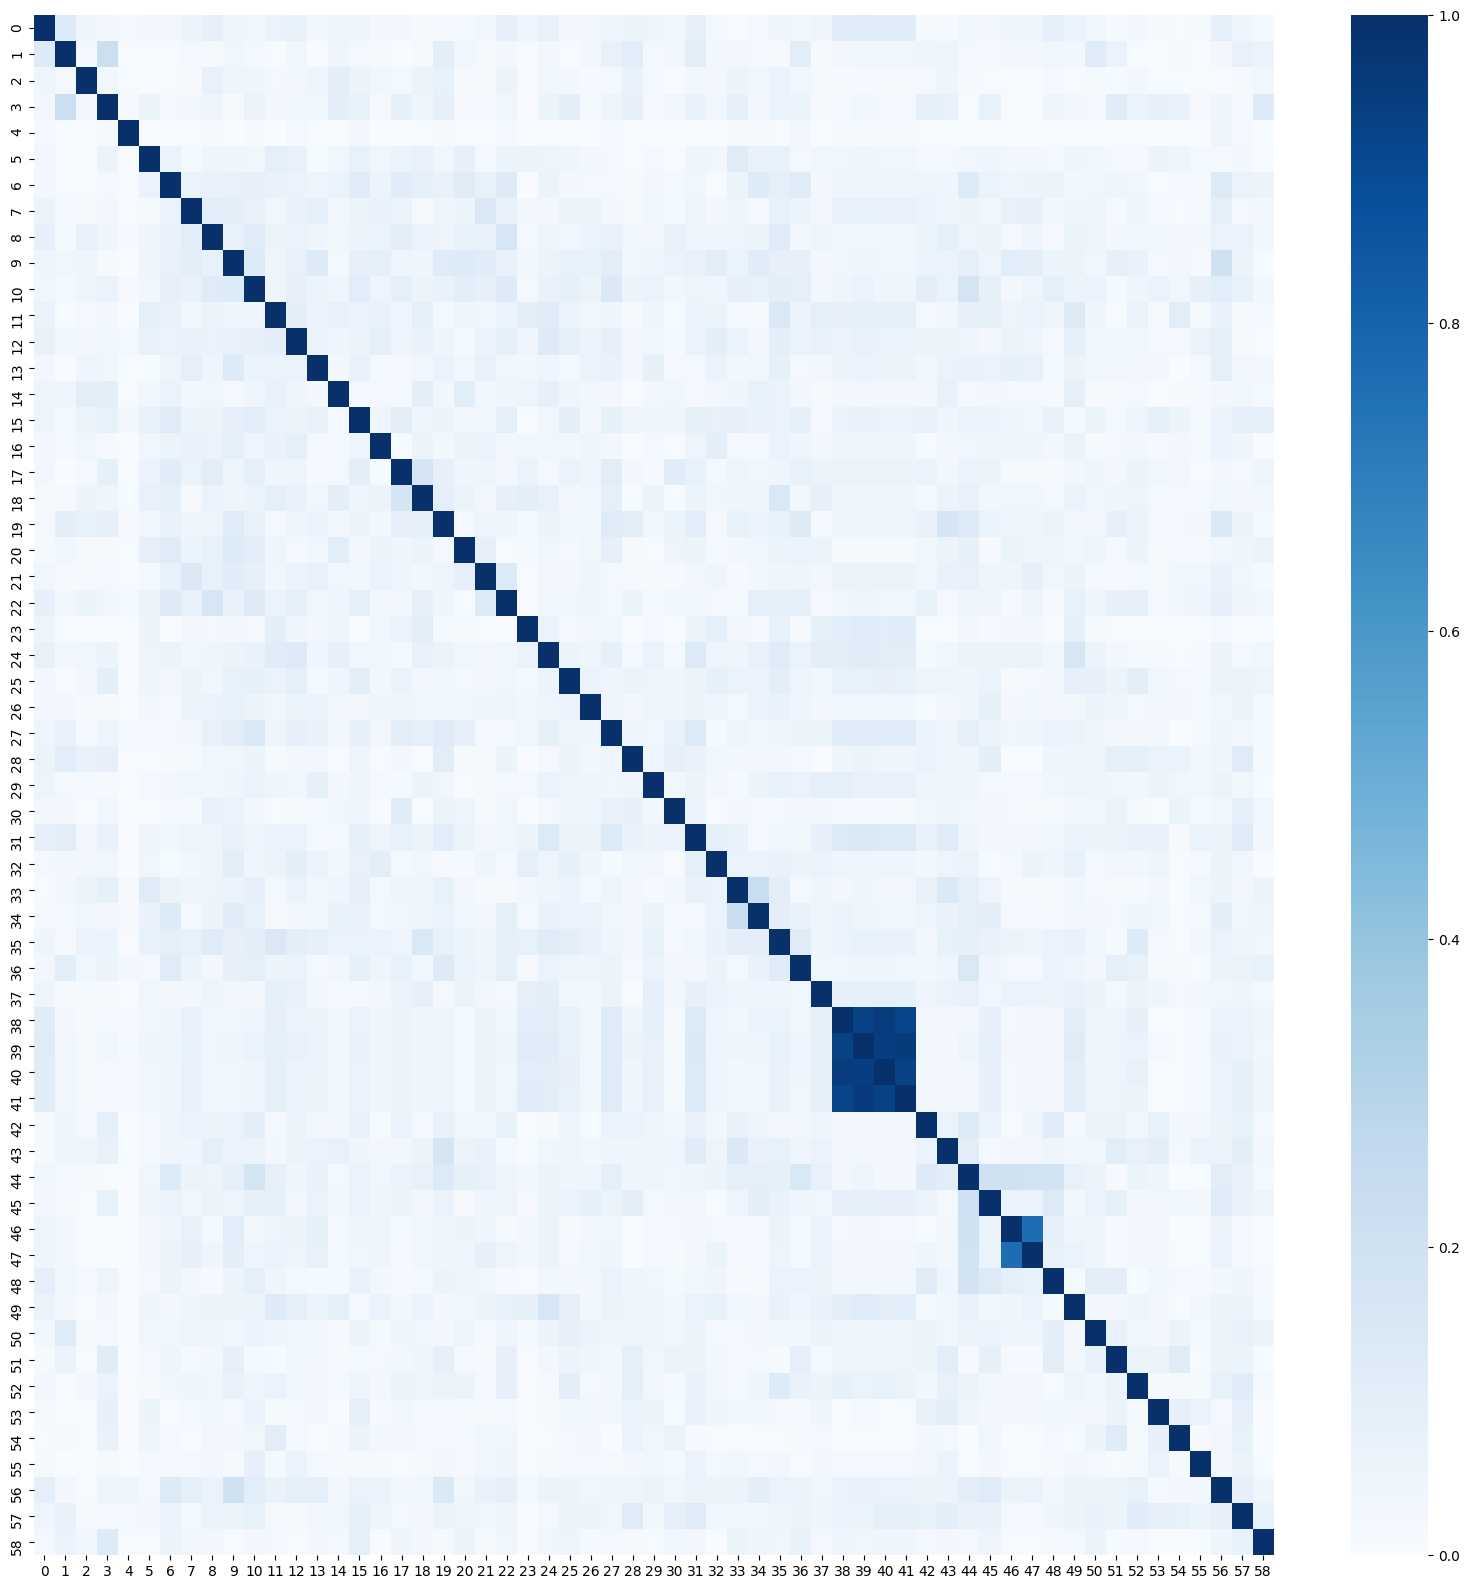

In [28]:
plt.figure(figsize = (20, 20))
sns.heatmap(pd.DataFrame(cosine_similarity(tfidf), index = tfidf.index, columns = tfidf.index), cmap = 'Blues')
plt.show()

In [30]:
d.iloc[[38,39,40,41], :]

,Unnamed: 0,회사명,직무명,채용공고명,주요업무,자격요건,우대사항,기술스택
38,833,이랜드이노플,웹 개발자,이랜드몰 JAVA 개발자 정산 파트,이랜드몰 e commerce 플랫폼 서비스 백엔드 개발 및 운영 정산 파트 ...,"Spring Framework Spring Boot JPA, Hiber...","이커머스 개발 경험 AWS GCP등 클라우드 경험 고성능, 대용량 시...",nan
39,834,이랜드이노플,웹 개발자,이랜드몰 JAVA 프레임워크,이랜드몰 e commerce 플랫폼 서비스 백엔드 개발 및 운영 Rest...,"Spring framework SpringBoot JPA, Hiber...","이커머스 개발 경험 AWS GCP등 클라우드 경험 고성능, 대용량 시...",nan
40,835,이랜드이노플,웹 개발자,이랜드몰 JAVA 개발자 주문 파트,이랜드몰 e commerce 플랫폼 서비스 백엔드 개발 및 운영 주문파트 ...,"Spring Framework Spring Boot JPA, Hiber...","이커머스 개발 경험 AWS GCP등 클라우드 경험 고성능, 대용량 시...",nan
41,836,이랜드이노플,웹 개발자,"이랜드몰 JAVA 전시, 상품",이랜드몰 e commerce 플랫폼 서비스 백엔드 개발 및 운영 Rest...,"Spring Framework Spring Boot JPA, Hiber...","이커머스 개발 경험 AWS GCP등 클라우드 경험 고성능, 대용량 시...",nan


In [31]:
d.iloc[[46,47], :]

,Unnamed: 0,회사명,직무명,채용공고명,주요업무,자격요건,우대사항,기술스택
46,864,오케스트로,웹 개발자,Cloud Engineer Openstack,OpenStack 구축 및 장애 대응 IaC를 통한 OpenStack 자동...,클라우드에 관심이 많으신 분 리눅스 서버를 다뤄보신 분 다양한 오픈...,openstack을 설치 활용 해보신 분 클라우드 자격증을 보유 하신 분 ...,Python
47,865,오케스트로,웹 개발자,Cloud Engineer Kubernetes,Kubernetes 구축 및 장애 대응 IaC를 통한 kuberbetes ...,클라우드에 관심이 많으신 분 리눅스 서버를 다뤄보신 분 다양한 오픈소...,kubernetes 설치 활용 해보신 분 클라우드 자격증을 보유 하신 분 ...,Python
